## Setup (install and import libraries)

In [ ]:
pip install jaxlib==0.4.12

In [ ]:
pip install --upgrade e3nn-jax

In [ ]:
pip install jax-md --upgrade

In [ ]:
pip install diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.


In [ ]:
import jax.numpy as np
from jax.nn import relu
from jax import random
from jax import vmap
from jax_md.quantity import box_size_at_number_density
from jax_md.colab_tools import renderer
from jax_md import space
from jax_md import energy
from jax import grad, hessian, jacfwd, jacrev, jvp

from jax import config
config.update("jax_enable_x64", True)

from scipy.sparse import csgraph
import matplotlib.pyplot as plt

from diffrax import diffeqsolve, ODETerm, Dopri5, Euler, SaveAt, Tsit5, Kvaerno3, PIDController

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import ticker, cm
from matplotlib.patches import Circle
from itertools import product

## Overdamped

##Initialization of static particles

In [ ]:
key = random.PRNGKey(5)

particle_count = 20
dim = 2

# volume = 8
# number_density = particle_count / volume

box_size = box_size_at_number_density(particle_count = particle_count,
                                      number_density = 1.2,
                                      spatial_dimension = dim)

R = random.uniform(key, (particle_count, dim), maxval=0.5, minval=-0.5)

In [ ]:
displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

In [ ]:
# def potential(x):
#   eps = 1e3
#   sig = 0.1
#   thresh = 0.3
#   dist_x_R = metric(x, R)
#   return np.einsum('ij->', 4*eps*(np.power((sig/(dist_x_R + thresh)),12) - np.power((sig/(dist_x_R + thresh)),6)))
#   # return 4*eps*(np.power((sig/dist_x_R),12) - np.power((sig/dist_x_R),6))


def potential(x):
  dist_x_R = metric(x, R)
  return -0.1*np.einsum('ij->', np.exp(-np.square(dist_x_R/0.1))/np.sqrt(np.pi*0.1)) #before the prefactor was 0.01

batch_potential = vmap(potential)

In [ ]:
n_grid = 101
x_coord, y_coord = np.meshgrid(np.linspace(-0.5, 0.5, n_grid), np.linspace(-0.5, 0.5, n_grid))

In [ ]:
grid_points = np.array([x_coord, y_coord])
grid_list = np.reshape(np.transpose(grid_points), (n_grid*n_grid,1,2))
grid_potential = batch_potential(grid_list)

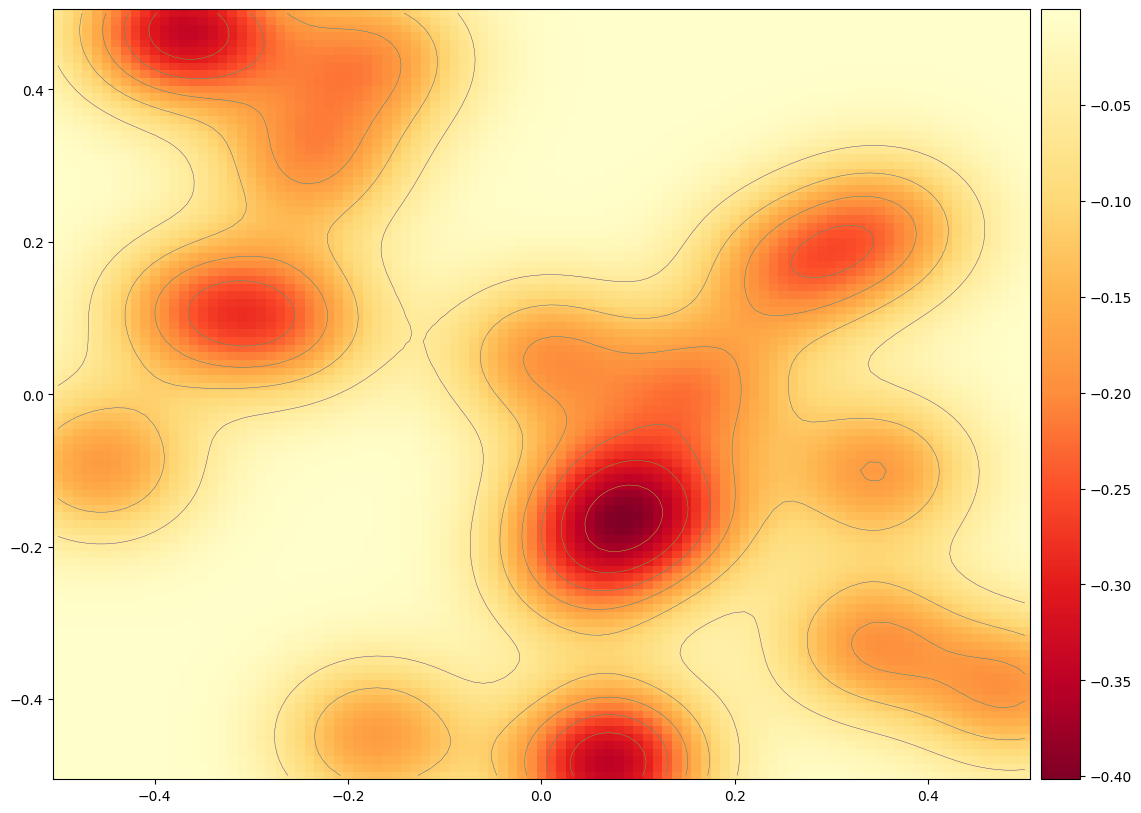

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r')
contour_plot = ax.contour(y_coord, x_coord, -np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.3, zorder=1)
fig.colorbar(heat_map, ax=ax, pad=0.01)

In [ ]:
def ctrl_hamiltonian_od(x,Lambda):
  gamma = 1e2
  eta = 1e2
  return -(1/2*gamma)*np.einsum('ij,ij->', Lambda, Lambda) - np.einsum('ij,ij->', jacrev(potential, argnums=0)(x), Lambda)
  #return -(1/(2*(1e6*potential(x)+0.001)))*np.einsum('ij,ij->', Lambda, Lambda)

In [ ]:
def terminal_cost(x):
  return np.sum(np.square(x - x_tar))

In [ ]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt

def fwd_dyn_od(t, G, args):
  x, Lambda = G
  xdot = jacrev(ctrl_hamiltonian_od, argnums=1)(x,Lambda)
  Lambdadot = -jacrev(ctrl_hamiltonian_od, argnums=0)(x,Lambda)
  F = [xdot, Lambdadot]
  return F

def bwd_dyn_od(t, U, args):
  xad, Lambdaad = U
  x, Lambda = args

  ind = 1000-1000*t-1
  ind = ind.astype(int)

  d2H_dR_dR = jacfwd(jacrev(ctrl_hamiltonian_od, argnums=0), argnums=0)(x[ind],Lambda[ind])
  d2H_dR_dP = jacfwd(jacrev(ctrl_hamiltonian_od, argnums=0), argnums=1)(x[ind],Lambda[ind])
  d2H_dP_dP = jacfwd(jacrev(ctrl_hamiltonian_od, argnums=1), argnums=1)(x[ind],Lambda[ind])

  xaddot = np.einsum('ij,ijkl', xad, d2H_dR_dP )  - np.einsum('ij,ijkl', Lambdaad, d2H_dR_dR)
  Lambdaaddot = np.einsum('ij,ijkl', xad, d2H_dP_dP )  - np.einsum('ij,ijkl', Lambdaad, d2H_dR_dP)
  V = [xaddot, Lambdaaddot]
  return V

In [ ]:
x0 = np.array([[0.2,-0.2]]) + random.uniform(random.PRNGKey(5), (1, dim), maxval=0.1, minval=-0.1)
Lambda0 = 0.0*np.ones(x0.shape)
x_tar = 0.0*np.ones(x0.shape)

n = 1000
dt0 = 1/n

pos = x0
traj = []

gamma = 1e2

In [ ]:
for k in range(100):

  print([k, np.sqrt(terminal_cost(pos))])

  traj.append(pos)

  t0 = k*dt0
  t1 = 0.1

  for i in range(100):
    # solver = Dopri5()
    solver = Euler()
    # stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

    # fwd_sol = diffeqsolve(ODETerm(fwd_dyn_od), solver, t0=t0, t1=t1, dt0=0.001, y0=[np.float64(x0),np.float64(Lambda0)], saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)
    fwd_sol = diffeqsolve(ODETerm(fwd_dyn_od), solver, t0=t0, t1=t1, dt0=dt0, y0=[np.float64(pos), np.float64(Lambda0)], saveat=SaveAt(ts=np.linspace(t0,t1,int((t1-t0)/dt0))), max_steps=None)

    args = fwd_sol.ys

    # xad0 = jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1])
    xad0 = np.zeros(x0.shape)
    #vad0 = np.zeros(v0.shape)
    # Lambdaad0 = np.zeros(Lambda0.shape)
    Lambdaad0 = fwd_sol.ys[1][-1] - jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1])
    #Muad0 = np.zeros(Mu0.shape)

    # xad0 = -np.einsum('ij,ijkl->kl', fwd_sol.ys[2][-1] - jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1]), jacfwd(jacrev(terminal_cost, argnums=0), argnums=0)(fwd_sol.ys[0][-1]) )
    # vad0 = np.zeros(v0.shape)
    # Lambdaad0 = -(fwd_sol.ys[2][-1] - jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1]))
    # Muad0 = np.zeros(Mu0.shape)

    # bwd_sol = diffeqsolve(ODETerm(bwd_dyn_od), solver, t0=t0, t1=t1, dt0=0.0000001, y0=[np.float64(xad0),np.float64(Lambdaad0)], args=args, saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)
    bwd_sol = diffeqsolve(ODETerm(bwd_dyn_od), solver, t0=t0, t1=t1, dt0=(t1-t0)/n, y0=[np.float64(xad0),np.float64(Lambdaad0)], args=args, saveat=SaveAt(ts=np.linspace(t0,t1,int((t1-t0)/dt0))), max_steps=None)

    key = random.PRNGKey(i)
    # eta_learning = 1e-3*random.uniform(key, minval=0.0, maxval=1.0)

    eta_learning = 1e-3
    Lambda0 = Lambda0 - eta_learning*bwd_sol.ys[1][-1]

  pos = pos + dt0*(jacrev(ctrl_hamiltonian_od, argnums=1)(pos,Lambda0))
  Lambda0 = Lambda0 + 1e-2*random.uniform(random.PRNGKey(k), (1, dim), minval=0.0, maxval=1.0)


traj.append(pos)

[0, Array(0.38362559, dtype=float64)]
[1, Array(0.38026729, dtype=float64)]
[2, Array(0.37672376, dtype=float64)]
[3, Array(0.37319743, dtype=float64)]
[4, Array(0.36964288, dtype=float64)]
[5, Array(0.3660948, dtype=float64)]
[6, Array(0.36257588, dtype=float64)]
[7, Array(0.35895081, dtype=float64)]
[8, Array(0.35535564, dtype=float64)]
[9, Array(0.35174189, dtype=float64)]
[10, Array(0.34805581, dtype=float64)]
[11, Array(0.34437873, dtype=float64)]
[12, Array(0.34058342, dtype=float64)]
[13, Array(0.33675935, dtype=float64)]
[14, Array(0.33299525, dtype=float64)]
[15, Array(0.32916297, dtype=float64)]
[16, Array(0.32531733, dtype=float64)]
[17, Array(0.32146756, dtype=float64)]
[18, Array(0.31766529, dtype=float64)]
[19, Array(0.31388528, dtype=float64)]
[20, Array(0.30994709, dtype=float64)]
[21, Array(0.30605736, dtype=float64)]
[22, Array(0.30222036, dtype=float64)]
[23, Array(0.29841042, dtype=float64)]
[24, Array(0.29448546, dtype=float64)]
[25, Array(0.29061053, dtype=float64

In [ ]:
traj_arr = np.array(traj)

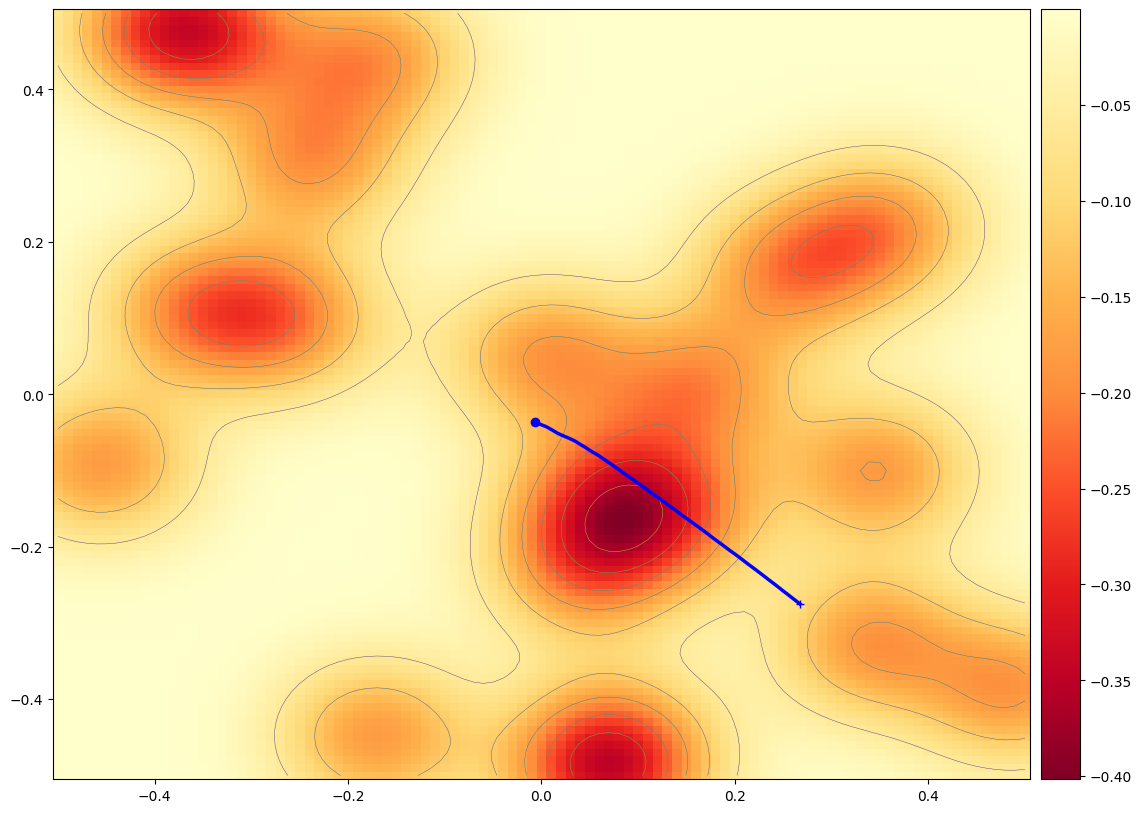

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r')
contour_plot = ax.contour(y_coord, x_coord, -np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.3, zorder=1)
fig.colorbar(heat_map, ax=ax, pad=0.01)

# ax.plot(fwd_sol.ys[0][:,0,0], fwd_sol.ys[0][:,0,1], linewidth=2.5, c='b')
# ax.plot(fwd_sol.ys[0][-1,0,0], fwd_sol.ys[0][-1,0,1], 'o', c='b')
# ax.plot(fwd_sol.ys[0][0,0,0], fwd_sol.ys[0][0,0,1], '+', c='b')

ax.plot(traj_arr[:,0,0], traj_arr[:,0,1], linewidth=2.5, c='b')
ax.plot(traj_arr[-1,0,0], traj_arr[-1,0,1], 'o', c='b')
ax.plot(traj_arr[0,0,0], traj_arr[0,0,1], '+', c='b')

##Changing magnitude of V

In [ ]:
fwd_sol_mag_0_01_t_0_12=fwd_sol

In [ ]:
fwd_sol_mag_0_05_t_0_12=fwd_sol

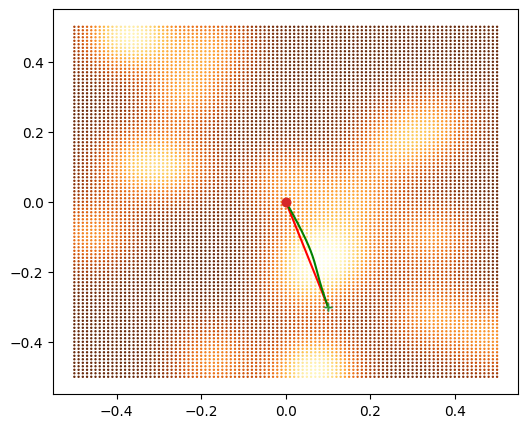

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=grid_color, cmap='YlOrBr')
#plt.colorbar()

#plt.colorbar()
#plt.scatter(fwd_sol_pot_2_t_0_20.ys[0][:,0,0], fwd_sol_pot_2_t_0_20.ys[0][:,0,1],c=np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_20.ys[1],fwd_sol_pot_2_t_0_20.ys[1]),s=0.01,cmap='PuBuGn')
#plt.plot(fwd_sol_pot_2_t_0_20.ys[0][0,0,0], fwd_sol_pot_2_t_0_20.ys[0][0,0,1], '+')
#plt.plot(fwd_sol_pot_2_t_0_20.ys[0][-1,0,0], fwd_sol_pot_2_t_0_20.ys[0][-1,0,1], 'o')

#plt.colorbar()

#plt.scatter(fwd_sol_pot_2_t_0_12.ys[0][:,0,0], fwd_sol_pot_2_t_0_12.ys[0][:,0,1],c=np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_12.ys[1],fwd_sol_pot_2_t_0_12.ys[1]),s=0.01,cmap='Reds')
plt.plot(fwd_sol_mag_0_01_t_0_12.ys[0][:,0,0], fwd_sol_mag_0_01_t_0_12.ys[0][:,0,1],'r', label='T=0.12')
plt.plot(fwd_sol_mag_0_01_t_0_12.ys[0][0,0,0], fwd_sol_mag_0_01_t_0_12.ys[0][0,0,1], '+')
plt.plot(fwd_sol_mag_0_01_t_0_12.ys[0][-1,0,0], fwd_sol_mag_0_01_t_0_12.ys[0][-1,0,1], 'o')
#plt.colorbar()

#plt.scatter(fwd_sol_pot_2_t_0_1.ys[0][:,0,0], fwd_sol_pot_2_t_0_1.ys[0][:,0,1],c=np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_1.ys[1],fwd_sol_pot_2_t_0_1.ys[1]),s=0.01,cmap='Greys')
plt.plot(fwd_sol_mag_0_05_t_0_12.ys[0][:,0,0], fwd_sol_mag_0_05_t_0_12.ys[0][:,0,1],'g',label='T=0.1')
plt.plot(fwd_sol_mag_0_05_t_0_12.ys[0][0,0,0], fwd_sol_mag_0_05_t_0_12.ys[0][0,0,1], '+')
plt.plot(fwd_sol_mag_0_05_t_0_12.ys[0][-1,0,0], fwd_sol_mag_0_05_t_0_12.ys[0][-1,0,1], 'o')

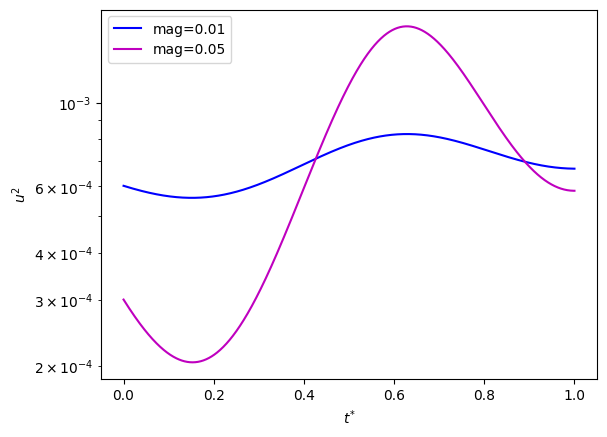

In [ ]:
#plt.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_12.ys[1],fwd_sol_pot_2_t_0_12.ys[1]),'-r',label='T=0.12')
#plt.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_1.ys[1],fwd_sol_pot_2_t_0_1.ys[1]),'-g',label='T=0.1')
plt.plot(fwd_sol_mag_0_01_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_mag_0_01_t_0_12.ys[1],fwd_sol_mag_0_01_t_0_12.ys[1]),'-b',label='mag=0.01')
plt.plot(fwd_sol_mag_0_01_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_mag_0_05_t_0_12.ys[1],fwd_sol_mag_0_05_t_0_12.ys[1]),'-m', label='mag=0.05')
plt.yscale('log')
plt.ylabel(r'$u^2$')
plt.xlabel(r'$t^{*}$')
plt.legend(loc='upper left')
#plt.savefig('ctrl_det_chang_T.eps', dpi=600)

##Changing K in the cost function

In [ ]:
fwd_sol_pot_0_N_0=fwd_sol

In [ ]:
fwd_sol_pot_0=fwd_sol

In [ ]:
fwd_sol_pot_1=fwd_sol

In [ ]:
fwd_sol_pot_2=fwd_sol

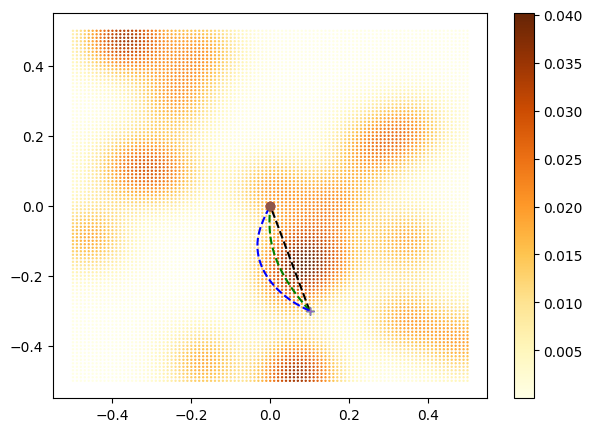

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=grid_color, cmap='YlOrBr')
plt.colorbar()
#plt.scatter(fwd_sol.ys[0][:,0,0], fwd_sol.ys[0][:,0,1],s=0.1,c=np.einsum('ij,ij->i',fwd_sol.ys[1][:,0,:],fwd_sol.ys[1][:,0,:]))
plt.plot(fwd_sol_pot_0.ys[0][:,0,0], fwd_sol_pot_0.ys[0][:,0,1],'--k')
plt.plot(fwd_sol_pot_0.ys[0][0,0,0], fwd_sol_pot_0.ys[0][0,0,1], '+')
plt.plot(fwd_sol_pot_0.ys[0][-1,0,0], fwd_sol_pot_0.ys[0][-1,0,1], 'o')
#plt.colorbar()
plt.plot(fwd_sol_pot_1.ys[0][:,0,0], fwd_sol_pot_1.ys[0][:,0,1],'--g')
plt.plot(fwd_sol_pot_1.ys[0][0,0,0], fwd_sol_pot_1.ys[0][0,0,1], '+')
plt.plot(fwd_sol_pot_1.ys[0][-1,0,0], fwd_sol_pot_1.ys[0][-1,0,1], 'o')
#plt.colorbar()
plt.plot(fwd_sol_pot_2.ys[0][:,0,0], fwd_sol_pot_2.ys[0][:,0,1],'--b')
plt.plot(fwd_sol_pot_2.ys[0][0,0,0], fwd_sol_pot_2.ys[0][0,0,1], '+')
plt.plot(fwd_sol_pot_2.ys[0][-1,0,0], fwd_sol_pot_2.ys[0][-1,0,1], 'o')
#plt.colorbar()
#plt.plot(fwd_sol_pot_3.ys[0][:,0,0], fwd_sol_pot_3.ys[0][:,0,1])
#plt.plot(fwd_sol_pot_3.ys[0][0,0,0], fwd_sol_pot_3.ys[0][0,0,1], '+')
#plt.plot(fwd_sol_pot_3.ys[0][-1,0,0], fwd_sol_pot_3.ys[0][-1,0,1], 'o')
#plt.colorbar()
#plt.plot(fwd_sol_pot_10.ys[0][:,0,0], fwd_sol_pot_10.ys[0][:,0,1])
#plt.plot(fwd_sol_pot_10.ys[0][0,0,0], fwd_sol_pot_10.ys[0][0,0,1], '+')
#plt.plot(fwd_sol_pot_10.ys[0][-1,0,0], fwd_sol_pot_10.ys[0][-1,0,1], 'o')

In [ ]:
T=100

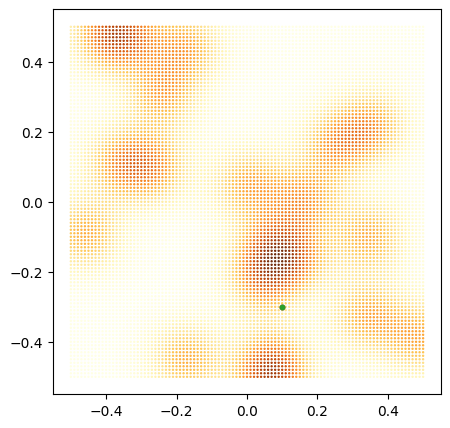

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(i):
    ax.clear()
    bgrnd = ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=grid_color, cmap='YlOrBr')
    fgrnd1 = ax.scatter(fwd_sol_pot_0.ys[0][10*i,0,0], fwd_sol_pot_0.ys[0][10*i,0,1], s=10)
    fgrnd2 = ax.scatter(fwd_sol_pot_1.ys[0][10*i,0,0], fwd_sol_pot_1.ys[0][10*i,0,1], s=10)
    fgrnd3 = ax.scatter(fwd_sol_pot_2.ys[0][10*i,0,0], fwd_sol_pot_2.ys[0][10*i,0,1], s=10)
    traj1= ax.plot(fwd_sol_pot_0.ys[0][0:10*i,0,0],fwd_sol_pot_0.ys[0][0:10*i,0,1],'--k')
    traj2= ax.plot(fwd_sol_pot_1.ys[0][0:10*i,0,0],fwd_sol_pot_1.ys[0][0:10*i,0,1],'--g')
    traj3= ax.plot(fwd_sol_pot_2.ys[0][0:10*i,0,0],fwd_sol_pot_2.ys[0][0:10*i,0,1],'--b')
    #return bgrnd,fgrnd
    return fgrnd1,fgrnd2,fgrnd3,traj1, traj2, traj3,bgrnd

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=T)
ani.save("landscape_navigation.gif", dpi=300, writer=PillowWriter(fps=10))

##Changing time of Horizon

In [ ]:
fwd_sol_pot_2_t_0_01=fwd_sol

In [ ]:
fwd_sol_pot_2_t_0_05=fwd_sol

In [ ]:
fwd_sol_pot_2_t_0_1=fwd_sol

In [ ]:
fwd_sol_pot_2_t_0_12=fwd_sol

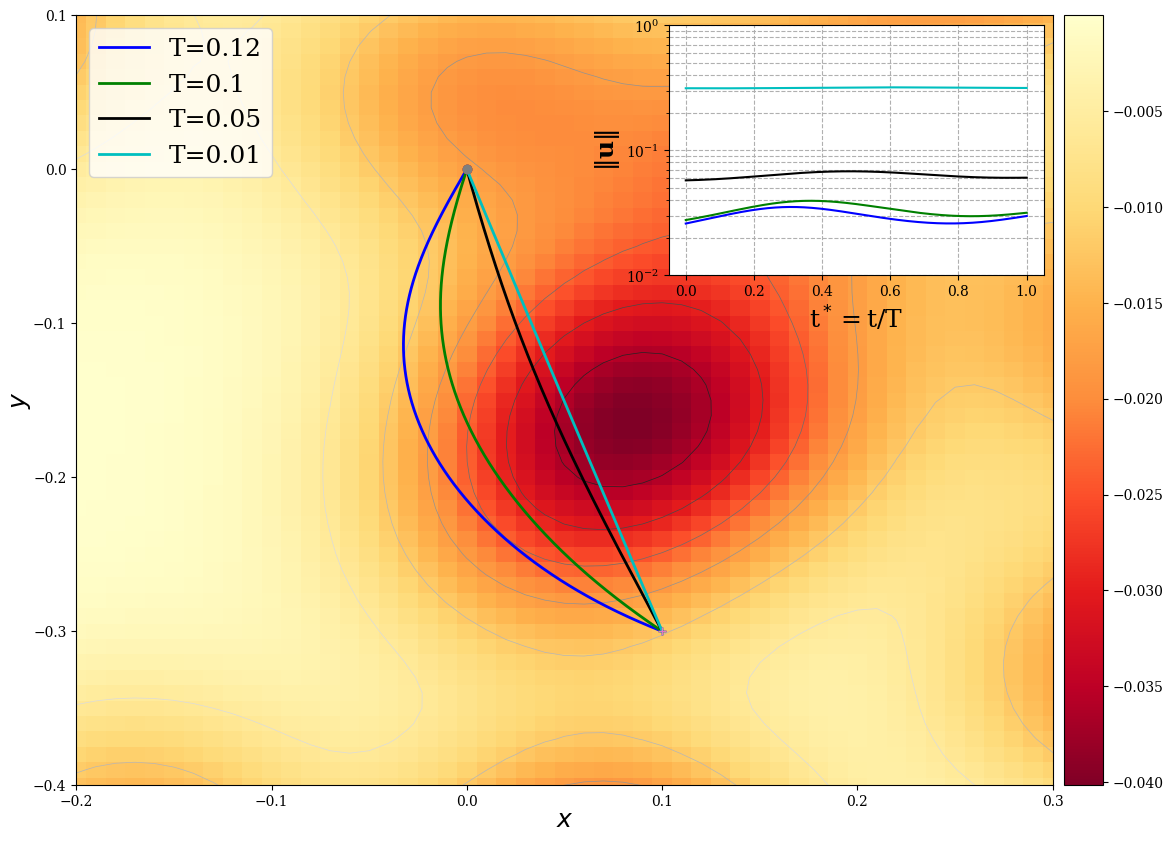

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r')
contour_plot = ax.contour(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.5, zorder=1, cmap='gray')
ax.plot(fwd_sol_pot_2_t_0_12.ys[0][:,0,0], fwd_sol_pot_2_t_0_12.ys[0][:,0,1],'b', label='T=0.12',linewidth=2.0)
ax.plot(fwd_sol_pot_2_t_0_12.ys[0][0,0,0], fwd_sol_pot_2_t_0_12.ys[0][0,0,1], '+')
ax.plot(fwd_sol_pot_2_t_0_12.ys[0][-1,0,0], fwd_sol_pot_2_t_0_12.ys[0][-1,0,1], 'o')

plt.plot(fwd_sol_pot_2_t_0_1.ys[0][:,0,0], fwd_sol_pot_2_t_0_1.ys[0][:,0,1],'g',label='T=0.1',linewidth=2.0)
plt.plot(fwd_sol_pot_2_t_0_1.ys[0][0,0,0], fwd_sol_pot_2_t_0_1.ys[0][0,0,1], '+')
plt.plot(fwd_sol_pot_2_t_0_1.ys[0][-1,0,0], fwd_sol_pot_2_t_0_1.ys[0][-1,0,1], 'o')

plt.plot(fwd_sol_pot_2_t_0_05.ys[0][:,0,0], fwd_sol_pot_2_t_0_05.ys[0][:,0,1],'k',label='T=0.05',linewidth=2.0)
plt.plot(fwd_sol_pot_2_t_0_05.ys[0][0,0,0], fwd_sol_pot_2_t_0_05.ys[0][0,0,1], '+')
plt.plot(fwd_sol_pot_2_t_0_05.ys[0][-1,0,0], fwd_sol_pot_2_t_0_05.ys[0][-1,0,1], 'o')

plt.plot(fwd_sol_pot_2_t_0_01.ys[0][:,0,0], fwd_sol_pot_2_t_0_01.ys[0][:,0,1],'c',label='T=0.01',linewidth=2.0)
plt.plot(fwd_sol_pot_2_t_0_01.ys[0][0,0,0], fwd_sol_pot_2_t_0_01.ys[0][0,0,1], '+')
plt.plot(fwd_sol_pot_2_t_0_01.ys[0][-1,0,0], fwd_sol_pot_2_t_0_01.ys[0][-1,0,1], 'o')

ax.set_xlim(-0.2,0.3)
ax.set_ylim(-0.4,0.1)
ax.legend(loc='upper left',fontsize=18)
fig.colorbar(heat_map, ax=ax, pad=0.01)
ax.set_xlabel(r'$x$', fontsize=18, labelpad=0)
ax.set_ylabel(r'$y$', fontsize=18, labelpad=0)


left, bottom, width, height = [0.52, 0.62, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.sqrt(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_12.ys[1],fwd_sol_pot_2_t_0_12.ys[1])),'-b',label='T=0.12')
ax2.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.sqrt(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_1.ys[1],fwd_sol_pot_2_t_0_1.ys[1])),'-g',label='T=0.1')
ax2.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.sqrt(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_05.ys[1],fwd_sol_pot_2_t_0_05.ys[1])),'-k',label='T=0.05')
ax2.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.sqrt(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_01.ys[1],fwd_sol_pot_2_t_0_01.ys[1])),'-c', label='T=0.01')
ax2.set_yscale('log')
ax2.set_ylabel(r'$\|$u$\|$', fontsize=18, weight='bold', labelpad=2.5)
ax2.set_xlabel(r't$^*=$t/T',fontsize=18)
ax2.set_ylim(0.01,1)
ax2.grid(linestyle='--',which='both')


#ax2.legend(loc='upper left')
fig.savefig('det_landscape_single_particle.pdf', bbox_inches='tight')

In [ ]:
ctrl_t_0_01=np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_01.ys[1],fwd_sol_pot_2_t_0_01.ys[1])
ctrl_t_0_12=np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_12.ys[1],fwd_sol_pot_2_t_0_12.ys[1])

In [ ]:
(np.sum(ctrl_t_0_01)*(0.01/1000))/(np.sum(ctrl_t_0_12)*(0.12/1000))

Array(9.20229158, dtype=float64)

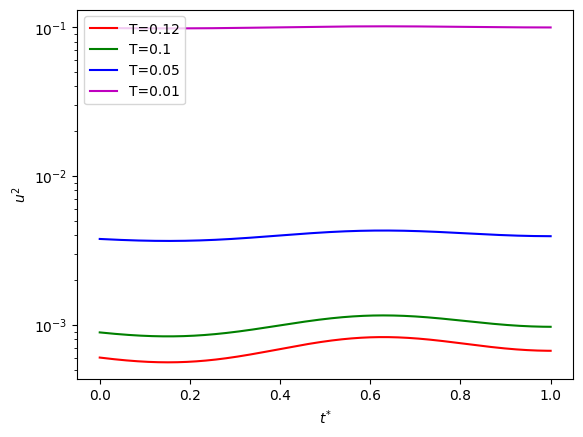

In [ ]:
#plt.plot(fwd_sol_pot_2_t_0_20.ys[0][:,0,0],np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_20.ys[1],fwd_sol_pot_2_t_0_20.ys[1]),'-k')
plt.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_12.ys[1],fwd_sol_pot_2_t_0_12.ys[1]),'-r',label='T=0.12')
plt.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_1.ys[1],fwd_sol_pot_2_t_0_1.ys[1]),'-g',label='T=0.1')
plt.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_05.ys[1],fwd_sol_pot_2_t_0_05.ys[1]),'-b',label='T=0.05')
plt.plot(fwd_sol_pot_2_t_0_12.ts/0.12,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_01.ys[1],fwd_sol_pot_2_t_0_01.ys[1]),'-m', label='T=0.01')
plt.yscale('log')
plt.ylabel(r'$u^2$')
plt.xlabel(r'$t^{*}$')
plt.legend(loc='upper left')
plt.savefig('ctrl_det_chang_T.eps', dpi=600)

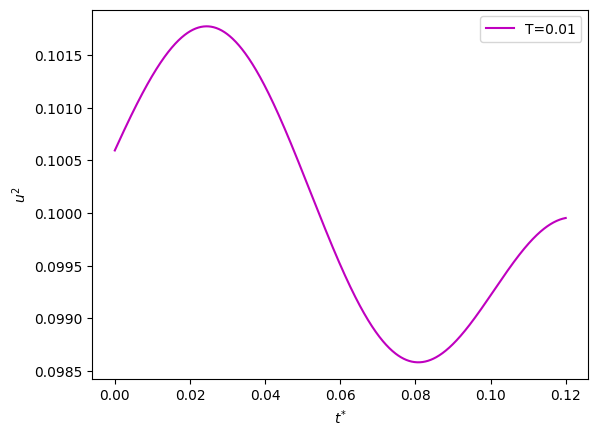

In [ ]:
#plt.plot(fwd_sol_pot_2_t_0_20.ys[0][:,0,0],np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_20.ys[1],fwd_sol_pot_2_t_0_20.ys[1]),'-k')
#plt.plot(fwd_sol_pot_2_t_0_12.ts,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_12.ys[1],fwd_sol_pot_2_t_0_12.ys[1]),'-r',label='T=0.12')
#plt.plot(fwd_sol_pot_2_t_0_12.ts,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_1.ys[1],fwd_sol_pot_2_t_0_1.ys[1]),'-g',label='T=0.1')
#plt.plot(fwd_sol_pot_2_t_0_12.ts,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_05.ys[1],fwd_sol_pot_2_t_0_05.ys[1]),'-b',label='T=0.05')
plt.plot(fwd_sol_pot_2_t_0_12.ts,np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_01.ys[1],fwd_sol_pot_2_t_0_01.ys[1]),'-m', label='T=0.01')
#plt.yscale('log')
plt.ylabel(r'$u^2$')
plt.xlabel(r'$t^{*}$')
plt.legend(loc='upper right')
plt.savefig('ctrl_det_chang_T_inset.eps', dpi=600)

In [ ]:
np.mean(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_20.ys[1],fwd_sol_pot_2_t_0_20.ys[1]))

Array(0.00106531, dtype=float64)

In [ ]:
np.mean(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_11.ys[1],fwd_sol_pot_2_t_0_11.ys[1]))

Array(0.0027524, dtype=float64)

In [ ]:
np.mean(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_1.ys[1],fwd_sol_pot_2_t_0_1.ys[1]))

Array(0.0032974, dtype=float64)

In [ ]:
np.mean(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_05.ys[1],fwd_sol_pot_2_t_0_05.ys[1]))

Array(0.0128713, dtype=float64)

In [ ]:
np.mean(np.einsum('ijk,ijk->ij',fwd_sol_pot_2_t_0_01.ys[1],fwd_sol_pot_2_t_0_01.ys[1]))

Array(0.32025857, dtype=float64)

In [ ]:
#traj=fwd_sol_pot_2_t_0_01.ys[0][:,0,:]
#traj=fwd_sol_pot_2_t_0_05.ys[0][:,0,:]
#traj=fwd_sol_pot_2_t_0_1.ys[0][:,0,:]
traj=fwd_sol_pot_2_t_0_12.ys[0][:,0,:]

In [ ]:
cos_theta_dist=[]
for x in range(998):
  vec1=traj[x+1]-traj[x]
  vec2=traj[x+600]-traj[x+599]
  dot_product=np.dot(vec1,vec2)
  if(np.linalg.norm(vec1)>0 and np.linalg.norm(vec2)>0):
    cos_theta_dist.append(dot_product/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))



In [ ]:
cos_theta_dist=np.array(cos_theta_dist)

In [ ]:
np.mean(cos_theta_dist)

Array(0.48121591, dtype=float64)

In [ ]:
t=[0.01,0.05,0.1,0.12]
cos_theta_mean=[0.99998994,0.99099797,0.71277636,0.48121591]

In [ ]:
np.array(t)[:]

Array([0.01, 0.05, 0.1 , 0.12], dtype=float64)

In [ ]:
cos_theta_mean=np.array(cos_theta_mean)
t=np.array(t)

Text(0, 0.5, '$\\langle cos \\theta \\rangle$')

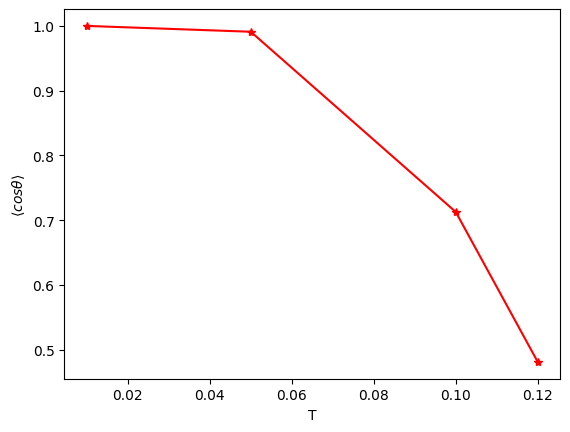

In [ ]:
plt.plot(t,cos_theta_mean,'-r',marker='*')
plt.xlabel("T")
plt.ylabel(r'$\langle cos \theta \rangle$')

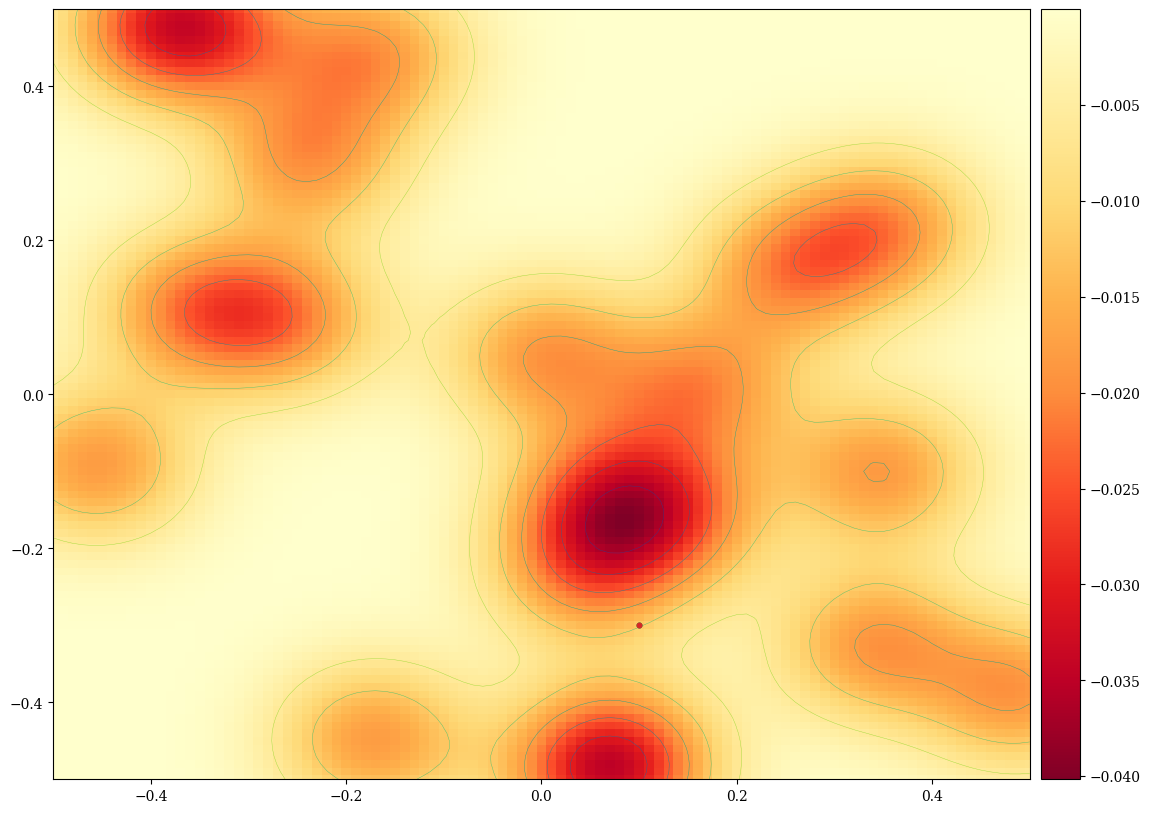

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

counter=0

def animate(i):
    ax.clear()
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(-0.5,0.5)

    #bgrnd = ax.scatter(grid_list[:,0,0], grid_list[:,0,1], s=0.5, c=grid_color, cmap='YlOrBr')
    heat_map = ax.pcolormesh(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), cmap='YlOrRd_r')
    contour_plot = ax.contour(y_coord, x_coord, np.reshape(np.squeeze(np.transpose(grid_potential)), (n_grid, n_grid)), linewidths=0.3, zorder=1)
    fgrnd1 = ax.scatter(fwd_sol_pot_2_t_0_12.ys[0][10*i,0,0], fwd_sol_pot_2_t_0_12.ys[0][10*i,0,1], s=10)
    fgrnd2 = ax.scatter(fwd_sol_pot_2_t_0_1.ys[0][10*i,0,0], fwd_sol_pot_2_t_0_1.ys[0][10*i,0,1], s=10)
    fgrnd3 = ax.scatter(fwd_sol_pot_2_t_0_05.ys[0][10*i,0,0], fwd_sol_pot_2_t_0_05.ys[0][10*i,0,1], s=10)
    fgrnd4 = ax.scatter(fwd_sol_pot_2_t_0_01.ys[0][10*i,0,0], fwd_sol_pot_2_t_0_01.ys[0][10*i,0,1], s=10)
    traj1= ax.plot(fwd_sol_pot_2_t_0_12.ys[0][0:10*i,0,0],fwd_sol_pot_2_t_0_12.ys[0][0:10*i,0,1],'--b')
    traj2= ax.plot(fwd_sol_pot_2_t_0_1.ys[0][0:10*i,0,0],fwd_sol_pot_2_t_0_1.ys[0][0:10*i,0,1],'--g')
    traj3= ax.plot(fwd_sol_pot_2_t_0_05.ys[0][0:10*i,0,0],fwd_sol_pot_2_t_0_05.ys[0][0:10*i,0,1],'--k')
    traj4= ax.plot(fwd_sol_pot_2_t_0_01.ys[0][0:10*i,0,0],fwd_sol_pot_2_t_0_01.ys[0][0:10*i,0,1],'--c')

    if i==1:
      c_bar = fig.colorbar(heat_map, ax=ax, pad=0.01)
     # counter += 1
    else:
      c_bar = []

    #ax.legend(loc='upper left',fontsize=18)
    #if(i==0):
     # fig.colorbar(heat_map, ax=ax, pad=0.01)
    #return bgrnd,fgrnd

    return fgrnd1,fgrnd2,fgrnd3,fgrnd4,traj1, traj2, traj3, traj4, heat_map, contour_plot, c_bar

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=100)
ani.save("landscape_navigation_changing_T.gif", dpi=300, writer=PillowWriter(fps=10))

In [ ]:
np.einsum('ij,ij->i',fwd_sol.ys[1][:,0,:],fwd_sol.ys[1][:,0,:]).shape

(1000,)

In [ ]:
fwd_sol.ys[1][:,0,:].shape

(1000, 2)

##Many body control for moving onto a circle

In [ ]:
key = random.PRNGKey(10)

particle_count = 30 #before we had 30 particles
dim = 2

# volume = 8
# number_density = particle_count / volume

box_size = box_size_at_number_density(particle_count = particle_count,
                                      number_density = 1.2,
                                      spatial_dimension = dim)

R = random.uniform(key, (particle_count, dim), maxval=3, minval=-3)
x=R

In [ ]:
box_size

Array(5., dtype=float64, weak_type=True)

In [ ]:
from jax_md.colab_tools import renderer
renderer.render(box_size, renderer.Disk(R), resolution=(600, 600))

In [ ]:
def adjacency_mat(r,d):
  return np.where((r < d) & (r > 0),
                  1,
                  0.)

displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

dist_matrix = metric(x, x)

A = adjacency_mat(dist_matrix,1.5)
A = np.triu(A,0)

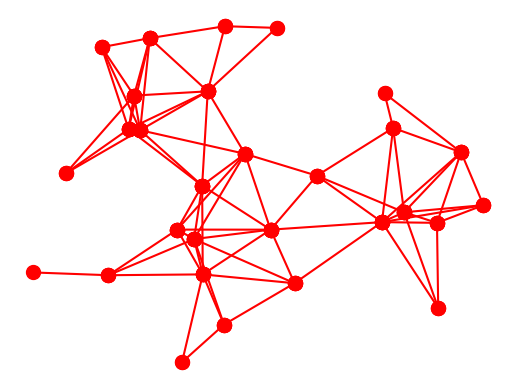

In [ ]:
fig, ax = plt.subplots()

X = np.array([x[np.where(A)[0]],x[np.where(A)[1]]])
ax.plot(X[:,:,0],X[:,:,1], 'ro-', zorder=1, markersize=10)
ax.axis('off')

plt.show()
fig.savefig('graph.pdf', bbox_inches='tight', facecolor='white')

In [ ]:
def energy_harmonic(x,K):
  dr = metric(x, x)
  return 0.5 *np.sum(np.multiply(K,np.square(dr - l)))

In [ ]:
def terminal_cost(x):
  return np.sum(np.square( np.linalg.norm(x,axis=1) - x_tar))

In [ ]:
def ctrl_hamiltonian_in_out(x,Lambda):
  gamma = 1e2
  eta = 1e2
  return -(1/2*gamma)*np.einsum('ij,ij->', Lambda, Lambda)  - np.einsum('ij,ij->', jacrev(energy_harmonic, argnums=0)(x,K), Lambda)

In [ ]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt

def fwd_dyn_od(t, G, args):
  x, Lambda = G
  xdot = jacrev(ctrl_hamiltonian_in_out, argnums=1)(x,Lambda)
  Lambdadot = -jacrev(ctrl_hamiltonian_in_out, argnums=0)(x,Lambda)
  F = [xdot, Lambdadot]
  return F

def bwd_dyn_od(t, U, args):
  xad, Lambdaad = U
  x, Lambda = args

  ind = 1000-1000*t-1
  ind = ind.astype(int)

  d2H_dR_dR = jacfwd(jacrev(ctrl_hamiltonian_in_out, argnums=0), argnums=0)(x[ind],Lambda[ind])
  d2H_dR_dP = jacfwd(jacrev(ctrl_hamiltonian_in_out, argnums=0), argnums=1)(x[ind],Lambda[ind])
  d2H_dP_dP = jacfwd(jacrev(ctrl_hamiltonian_in_out, argnums=1), argnums=1)(x[ind],Lambda[ind])

  xaddot = np.einsum('ij,ijkl', xad, d2H_dR_dP )  - np.einsum('ij,ijkl', Lambdaad, d2H_dR_dR)
  Lambdaaddot = np.einsum('ij,ijkl', xad, d2H_dP_dP )  - np.einsum('ij,ijkl', Lambdaad, d2H_dR_dP)
  V = [xaddot, Lambdaaddot]
  return V

In [ ]:
x0 = x
Lambda0 = 0.0*np.ones(x0.shape)
K=0.1
x_tar = 4
#t0 = 0
#t1 = 0.5
l=0.2
t0=0.0
t1=1.0

In [ ]:
np.linalg.norm(x0,axis=1)

Array([1.35304662, 2.97383429, 1.35569848, 1.70559883, 2.7578795 ,
       2.05288032, 2.63611501, 2.56836216, 3.98403361, 1.9331202 ,
       1.99334095, 2.23099824, 1.85462003, 1.93483025, 0.6696926 ,
       2.88157634, 1.6705004 , 2.57482982, 1.05184732, 0.50159048,
       2.29354575, 3.03838965, 0.76722817, 1.17668978, 0.83339125,
       2.26564138, 3.18737695, 2.51553397, 2.75820323, 2.38711584],      dtype=float64)

In [ ]:
for i in range(10000):
  solver = Dopri5()
  stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

  fwd_sol = diffeqsolve(ODETerm(fwd_dyn_od), solver, t0=t0, t1=t1, dt0=0.00001, y0=[np.float64(x0),np.float64(Lambda0)], saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)

  args = fwd_sol.ys

  xad0 = jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1])
  #vad0 = np.zeros(v0.shape)
  Lambdaad0 = np.zeros(Lambda0.shape)
  #Muad0 = np.zeros(Mu0.shape)

  # xad0 = -np.einsum('ij,ijkl->kl', fwd_sol.ys[2][-1] - jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1]), jacfwd(jacrev(terminal_cost, argnums=0), argnums=0)(fwd_sol.ys[0][-1]) )
  # vad0 = np.zeros(v0.shape)
  # Lambdaad0 = -(fwd_sol.ys[2][-1] - jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1]))
  # Muad0 = np.zeros(Mu0.shape)

  print([i, np.sqrt(terminal_cost(fwd_sol.ys[0][-1]))])

  bwd_sol = diffeqsolve(ODETerm(bwd_dyn_od), solver, t0=t0, t1=t1, dt0=0.00001, y0=[np.float64(xad0),np.float64(Lambdaad0)], args=args, saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)

  key = random.PRNGKey(i)
  eta_learning = 1e-7*random.uniform(key, minval=0.5, maxval=1.0)

  Lambda0 = Lambda0 - eta_learning*bwd_sol.ys[1][-1]
  #Mu0 = Mu0 + eta_learning*bwd_sol.ys[3][-1]

[0, Array(20.53435479, dtype=float64)]
[1, Array(14.02162289, dtype=float64)]
[2, Array(7.67043815, dtype=float64)]
[3, Array(2.48532754, dtype=float64)]
[4, Array(1.46290629, dtype=float64)]
[5, Array(0.75761322, dtype=float64)]
[6, Array(0.30345251, dtype=float64)]
[7, Array(0.17196843, dtype=float64)]
[8, Array(0.09727057, dtype=float64)]
[9, Array(0.04963933, dtype=float64)]
[10, Array(0.03344217, dtype=float64)]
[11, Array(0.02248401, dtype=float64)]
[12, Array(0.01176377, dtype=float64)]
[13, Array(0.00719657, dtype=float64)]
[14, Array(0.00463143, dtype=float64)]
[15, Array(0.003151, dtype=float64)]
[16, Array(0.00199363, dtype=float64)]
[17, Array(0.00141839, dtype=float64)]
[18, Array(0.0010799, dtype=float64)]
[19, Array(0.0006855, dtype=float64)]
[20, Array(0.00044424, dtype=float64)]
[21, Array(0.00031287, dtype=float64)]
[22, Array(0.0002424, dtype=float64)]
[23, Array(0.00018651, dtype=float64)]
[24, Array(0.00015328, dtype=float64)]
[25, Array(0.00012306, dtype=float64)]

KeyboardInterrupt: ignored

In [ ]:
fwd_sol

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1000],
  ys=[f64[1000,30,2], f64[1000,30,2]],
  interpolation=None,
  stats={
    'max_steps':
    None,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [ ]:
mechanical_energy_t_0_1=[]
for i in range(1000):
  mechanical_energy_t_0_1.append(energy_harmonic(sol_t_0_1.ys[0][i,:,:],K))

In [ ]:
mechanical_energy_t_0_1=np.array(mechanical_energy_t_0_1)

In [ ]:
mechanical_energy_t_0_5=[]
for i in range(1000):
  mechanical_energy_t_0_5.append(energy_harmonic(sol_t_0_5.ys[0][i,:,:],K))

In [ ]:
mechanical_energy_t_0_5=np.array(mechanical_energy_t_0_5)

In [ ]:
mechanical_energy_t_1=[]
for i in range(1000):
  mechanical_energy_t_1.append(energy_harmonic(sol_t_1.ys[0][i,:,:],K))

In [ ]:
mechanical_energy_t_1=np.array(mechanical_energy_t_1)

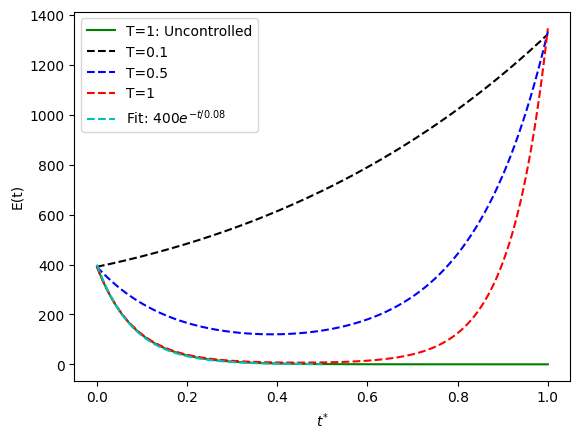

In [ ]:
plt.plot(fwd_sol.ts,mechanical_energy,'-g', label='T=1: Uncontrolled' )
plt.plot(fwd_sol.ts,mechanical_energy_t_0_1,'--k',label='T=0.1' )
plt.plot(fwd_sol.ts,mechanical_energy_t_0_5,'--b',label='T=0.5' )
plt.plot(fwd_sol.ts,mechanical_energy_t_1,'--r',label='T=1' )
plt.plot(fwd_sol.ts[0:500],400*np.exp(-fwd_sol.ts[0:500]/0.08),'--c',label=r'Fit: $400e^{-t/0.08}$')
plt.legend(loc='upper left')
plt.xlabel(r'$t^{*}$')
plt.ylabel('E(t)')
plt.savefig('mechanical_e.pdf', bbox_inches='tight')


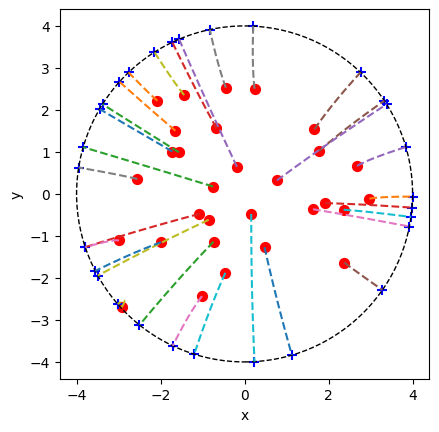

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

# print(harmonic_sol)
for i in range(particle_count):
  ax.plot(sol_t_0_1.ys[0][:,i,0],sol_t_0_1.ys[0][:,i,1],linestyle='--')
  ax.scatter(sol_t_0_1.ys[0][0,i,0],sol_t_0_1.ys[0][0,i,1],marker='o',s=50,c='r')
  ax.scatter(sol_t_0_1.ys[0][-1,i,0],sol_t_0_1.ys[0][-1,i,1],marker='+',s=50,c='b')
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
ax.add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#fig.savefig('traj_t_0_1.pdf', bbox_inches='tight')

#print(np.linalg.norm(fwd_sol.ys[0][-1],axis=1))

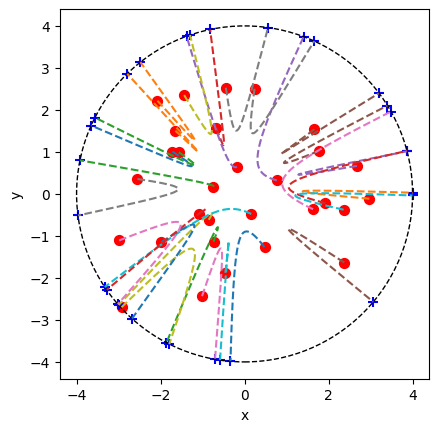

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

# print(harmonic_sol)
for i in range(particle_count):
  ax.plot(sol_t_0_5.ys[0][:,i,0],sol_t_0_5.ys[0][:,i,1],linestyle='--')
  ax.scatter(sol_t_0_5.ys[0][0,i,0],sol_t_0_5.ys[0][0,i,1],marker='o',s=50,c='r')
  ax.scatter(sol_t_0_5.ys[0][-1,i,0],sol_t_0_5.ys[0][-1,i,1],marker='+',s=50,c='b')
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
ax.add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#fig.savefig('traj_t_0_5.pdf', bbox_inches='tight')


#print(np.linalg.norm(fwd_sol.ys[0][-1],axis=1))

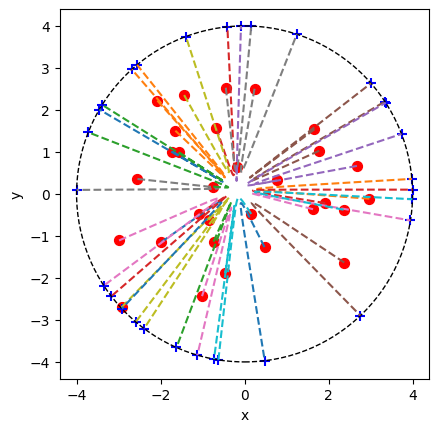

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

# print(harmonic_sol)
for i in range(particle_count):
  ax.plot(sol_t_1.ys[0][:,i,0],sol_t_1.ys[0][:,i,1],linestyle='--')
  ax.scatter(sol_t_1.ys[0][0,i,0],sol_t_1.ys[0][0,i,1],marker='o',s=50,c='r')
  ax.scatter(sol_t_1.ys[0][-1,i,0],sol_t_1.ys[0][-1,i,1],marker='+',s=50,c='b')
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
ax.add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#fig.savefig('traj_t_1.pdf', bbox_inches='tight')

#print(np.linalg.norm(fwd_sol.ys[0][-1],axis=1))

In [ ]:
sol=fwd_sol
sol

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1000],
  ys=[f64[1000,30,2], f64[1000,30,2]],
  interpolation=None,
  stats={
    'max_steps':
    None,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

##Make Movie

In [ ]:
T=100

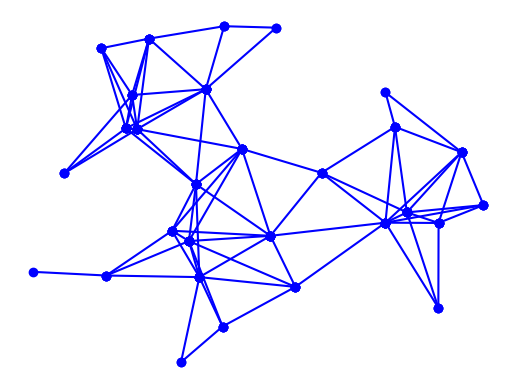

In [ ]:
fig, ax = plt.subplots()

X = np.array([sol.ys[0][i][np.where(A)[0]],sol.ys[0][i][np.where(A)[1]]])
ax.plot(X[:,:,0],X[:,:,1], 'bo-', zorder=1)
ax.axis('off')

plt.show()

In [ ]:
X=np.array([sol.ys[0][i][np.where(A)[0]],sol.ys[0][i][np.where(A)[1]]])
X.shape

(2, 77, 2)

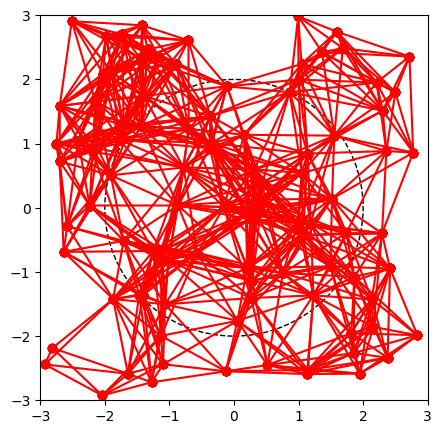

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(j):
    ax.clear()
    #bgrnd = ax.scatter(x_coord, y_coord, c=, s=10, cmap='YlOrRd')
    i=10*j
    X = np.array([sol.ys[0][i][np.where(A)[0]],sol.ys[0][i][np.where(A)[1]]])
    fgrnd1 = ax.plot(X[:,:,0],X[:,:,1], 'bo-')
    #fgrnd = ax.scatter(sol.ys[0][i,:,0], sol.ys[0][i,:,1], s=50)
    traj1= ax.plot(sol.ys[0][0:i,0,0],sol.ys[0][0:i,0,1],'--g')
    traj2= ax.plot(sol.ys[0][0:i,5,0],sol.ys[0][0:i,5,1],'--y')
    traj3= ax.plot(sol.ys[0][0:i,10,0],sol.ys[0][0:i,10,1],'--m')
    traj4= ax.plot(sol.ys[0][0:i,15,0],sol.ys[0][0:i,15,1],'--r')
    circ= ax.add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
    lim1= ax.set_xlim(-3, 3)
    lim2= ax.set_ylim(-3, 3)


    #return bgrnd,fgrnd
    return fgrnd1,circ

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=T)
ani.save("in_out_t_0_1.gif", dpi=300, writer=PillowWriter(fps=10))

##Plot Controls

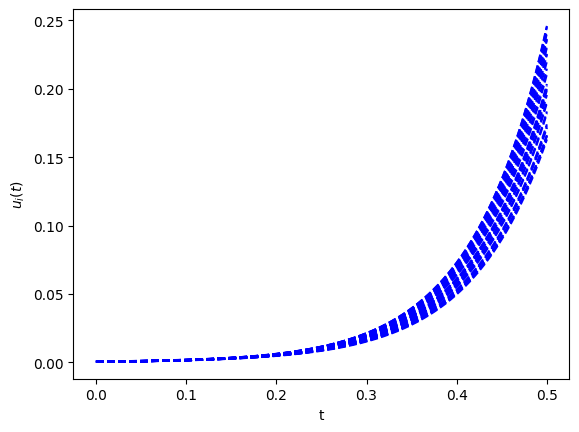

In [ ]:
for i in range(particle_count):
  plt.plot(sol_t_0_5.ts,np.einsum('ijk,ijk->ij',sol_t_0_5.ys[1],sol_t_0_5.ys[1])[:,i],'--b')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,5],'--y')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,10],'--m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,20],'--r')
plt.xlabel('t')
plt.ylabel(r'$u_i(t)$')
#plt.savefig('u_t_0_5.pdf', bbox_inches='tight')

Text(0, 0.5, '$u_i(t)$')

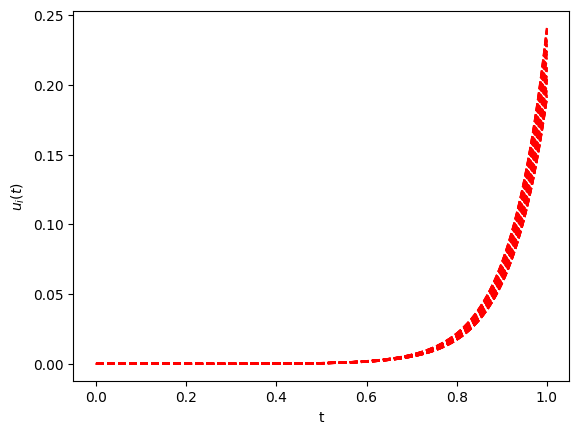

In [ ]:
for i in range(particle_count):
  plt.plot(sol_t_1.ts,np.einsum('ijk,ijk->ij',sol_t_1.ys[1],sol_t_1.ys[1])[:,i],'--r')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,5],'--y')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,10],'--m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,20],'--r')
plt.xlabel('t')
plt.ylabel(r'$u_i(t)$')
#plt.savefig('u_t_1.pdf', bbox_inches='tight')

In [ ]:
np.linalg.norm(x0,axis=1)

Array([1.35304662, 2.97383429, 1.35569848, 1.70559883, 2.7578795 ,
       2.05288032, 2.63611501, 2.56836216, 3.98403361, 1.9331202 ,
       1.99334095, 2.23099824, 1.85462003, 1.93483025, 0.6696926 ,
       2.88157634, 1.6705004 , 2.57482982, 1.05184732, 0.50159048,
       2.29354575, 3.03838965, 0.76722817, 1.17668978, 0.83339125,
       2.26564138, 3.18737695, 2.51553397, 2.75820323, 2.38711584],      dtype=float64)

Text(0, 0.5, '$u_i(t)$')

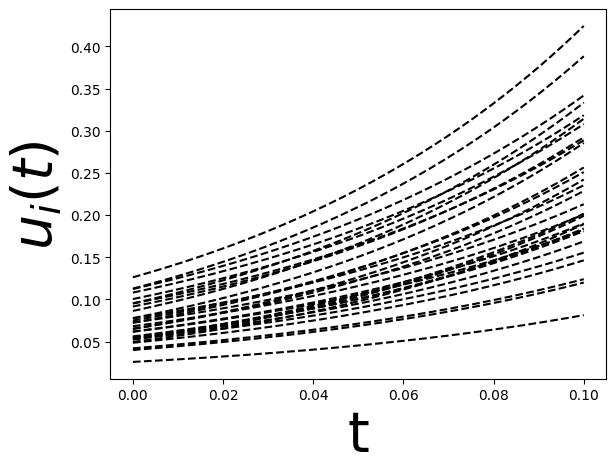

In [ ]:
for i in range(particle_count):
  plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,i],'--k')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,5],'--y')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,10],'--m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,20],'--r')
#plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,19],'--b')
#plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,26],'--m')
#plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,8],'--r')

plt.xlabel('t',fontsize=40)
plt.ylabel(r'$u_i(t)$',fontsize=40)
#plt.savefig('u_t_0_1.pdf', bbox_inches='tight')


In [ ]:
sol_t_1=fwd_sol

In [ ]:
sol_t_0_1=fwd_sol

In [ ]:
sol_t_0_5=fwd_sol

In [ ]:
sol_unc=fwd_sol

In [ ]:
ctrl_t_1=np.einsum('ijk,ijk->ij',sol_t_1.ys[1],sol_t_1.ys[1])
ctrl_t_0_1=np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])
ctrl_t_0_5=np.einsum('ijk,ijk->ij',sol_t_0_5.ys[1],sol_t_0_5.ys[1])

In [ ]:
np.sum(np.mean(ctrl_t_1,axis=1))

Array(17.99367822, dtype=float64)

In [ ]:
np.sum(np.mean(ctrl_t_0_1,axis=1))

Array(137.4516043, dtype=float64)

In [ ]:
np.sum(np.mean(ctrl_t_0_5,axis=1))

Array(34.07736159, dtype=float64)

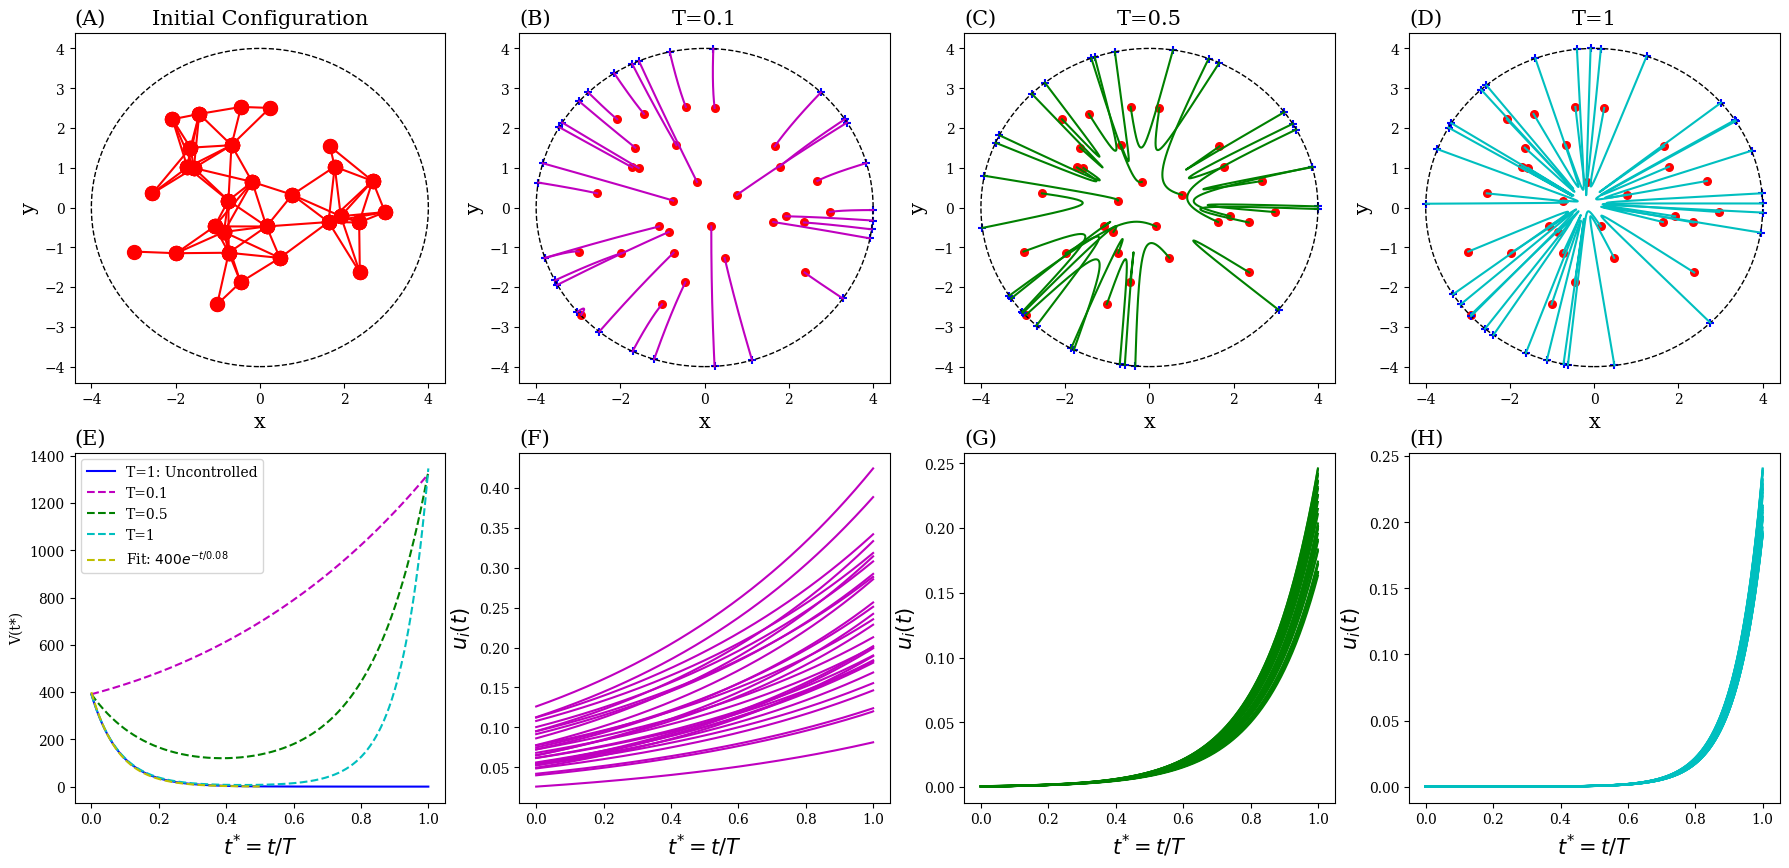

In [ ]:
figure, axis = plt.subplots(2,4,figsize=(22,10))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#X = np.array([x[np.where(A)[0]],x[np.where(A)[1]]])
axis[0,0].plot(X[:,:,0],X[:,:,1], 'ro-', zorder=1, markersize=10)
axis[0,0].add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
#axis[0,0].axis('off')
axis[0,0].set_title('Initial Configuration',loc='center',fontsize=15)
axis[0,0].set_xlabel('x',fontsize=15)
axis[0,0].set_ylabel('y',fontsize=15)
axis[0,0].set_title('(A)',loc='left',fontsize=15)

#axis[0,0].text(10,10, 'Parabola $Y = x^2$', fontsize = 22)


for i in range(particle_count):
  axis[0,1].plot(sol_t_0_1.ys[0][:,i,0],sol_t_0_1.ys[0][:,i,1],'m',linestyle='-')
  axis[0,1].scatter(sol_t_0_1.ys[0][0,i,0],sol_t_0_1.ys[0][0,i,1],marker='o',s=30,c='r')
  axis[0,1].scatter(sol_t_0_1.ys[0][-1,i,0],sol_t_0_1.ys[0][-1,i,1],marker='+',s=30,c='b')
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
axis[0,1].add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
axis[0,1].set_xlabel('x',fontsize=15)
axis[0,1].set_ylabel('y',fontsize=15)
axis[0,1].set_title('T=0.1',loc='center',fontsize=15)
axis[0,1].set_title('(B)',loc='left',fontsize=15)

#plt.show()

for i in range(particle_count):
  axis[0,2].plot(sol_t_0_5.ys[0][:,i,0],sol_t_0_5.ys[0][:,i,1],'g',linestyle='-')
  axis[0,2].scatter(sol_t_0_5.ys[0][0,i,0],sol_t_0_5.ys[0][0,i,1],marker='o',s=30,c='r')
  axis[0,2].scatter(sol_t_0_5.ys[0][-1,i,0],sol_t_0_5.ys[0][-1,i,1],marker='+',s=30,c='b')
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
axis[0,2].add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
axis[0,2].set_xlabel('x',fontsize=15)
axis[0,2].set_ylabel('y',fontsize=15)
axis[0,2].set_title('T=0.5',loc='center',fontsize=15)
axis[0,2].set_title('(C)',loc='left',fontsize=15)


for i in range(particle_count):
  axis[0,3].plot(sol_t_1.ys[0][:,i,0],sol_t_1.ys[0][:,i,1],'c',linestyle='-')
  axis[0,3].scatter(sol_t_1.ys[0][0,i,0],sol_t_1.ys[0][0,i,1],marker='o',s=30,c='r')
  axis[0,3].scatter(sol_t_1.ys[0][-1,i,0],sol_t_1.ys[0][-1,i,1],marker='+',s=30,c='b')
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
axis[0,3].add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
axis[0,3].set_xlabel('x',fontsize=15)
axis[0,3].set_ylabel('y',fontsize=15)
axis[0,3].set_title('T=1',loc='center',fontsize=15)
axis[0,3].set_title('(D)',loc='left',fontsize=15)



axis[1,0].plot(fwd_sol.ts,mechanical_energy,'-b', label='T=1: Uncontrolled' )
axis[1,0].plot(fwd_sol.ts,mechanical_energy_t_0_1,'--m',label='T=0.1' )
axis[1,0].plot(fwd_sol.ts,mechanical_energy_t_0_5,'--g',label='T=0.5' )
axis[1,0].plot(fwd_sol.ts,mechanical_energy_t_1,'--c',label='T=1' )
axis[1,0].plot(fwd_sol.ts[0:500],400*np.exp(-fwd_sol.ts[0:500]/0.08),'--y',label=r'Fit: $400e^{-t/0.08}$')
axis[1,0].legend(loc='upper left')
axis[1,0].set_xlabel(r'$t^{*}=t/T$',fontsize=15)
axis[1,0].set_ylabel('V(t*)')
axis[1,0].set_title('(E)',loc='left',fontsize=15)

for i in range(particle_count):
  axis[1,1].plot(sol_t_0_1.ts/0.1,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,i],'-m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,5],'--y')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,10],'--m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,20],'--r')
#plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,19],'--b')
#plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,26],'--m')
#plt.plot(sol_t_0_1.ts,np.einsum('ijk,ijk->ij',sol_t_0_1.ys[1],sol_t_0_1.ys[1])[:,8],'--r')

axis[1,1].set_xlabel(r'$t^{*}=t/T$',fontsize=15)
axis[1,1].set_ylabel(r'$u_i(t)$',fontsize=15)
#axis[1,1].set_title('T=0.1',loc='center',fontsize=15)
axis[1,1].set_title('(F)',loc='left',fontsize=15)

#plt.savefig('u_t_0_1.pdf', bbox_inches='tight')


for i in range(particle_count):
  axis[1,2].plot(sol_t_0_5.ts/0.5,np.einsum('ijk,ijk->ij',sol_t_0_5.ys[1],sol_t_0_5.ys[1])[:,i],'-g')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,5],'--y')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,10],'--m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,20],'--r')
axis[1,2].set_xlabel(r'$t^{*}=t/T$',fontsize=15)
axis[1,2].set_ylabel(r'$u_i(t)$',fontsize=15)
#axis[1,2].set_title('T=0.5',loc='center',fontsize=15)
axis[1,2].set_title('(G)',loc='left',fontsize=15)



for i in range(particle_count):
  axis[1,3].plot(sol_t_1.ts/1,np.einsum('ijk,ijk->ij',sol_t_1.ys[1],sol_t_1.ys[1])[:,i],'-c')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,5],'--y')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,10],'--m')
#plt.plot(sol.ts,np.einsum('ijk,ijk->ij',sol.ys[1],sol.ys[1])[:,20],'--r')
axis[1,3].set_xlabel(r'$t^{*}=t/T$',fontsize=15)
axis[1,3].set_ylabel(r'$u_i(t)$',fontsize=15)
#axis[1,3].set_title('T=1',loc='center',fontsize=15)
axis[1,3].set_title('(H)',loc='left',fontsize=15)

plt.savefig('gather_spread.pdf', bbox_inches='tight')



##Understanding the control correlations

In [ ]:
import numpy as nump

norm_ctrl = np.sqrt(np.einsum('ijk,ijk->ij', sol_t_0_1.ys[1], sol_t_0_1.ys[1]))

corr_matrix = nump.zeros((particle_count,particle_count))

for i in range(particle_count):
  for j in range(particle_count):
    dot_ctrl = np.einsum('ij,ij->i', sol_t_0_1.ys[1][:,j,:], sol_t_0_1.ys[1][:,i,:])
    corr_matrix[i,j] = np.mean(np.divide(dot_ctrl, np.multiply(norm_ctrl[:,j], norm_ctrl[:,i])))
    # plt.plot(sol_t_0_1.ts, np.divide(dot_ctrl, np.multiply(norm_ctrl[:,j], norm_ctrl[:,i])), '--k')

# plt.xlabel('t')
# plt.ylabel(r'$u_j \cdot u_i(t)$')

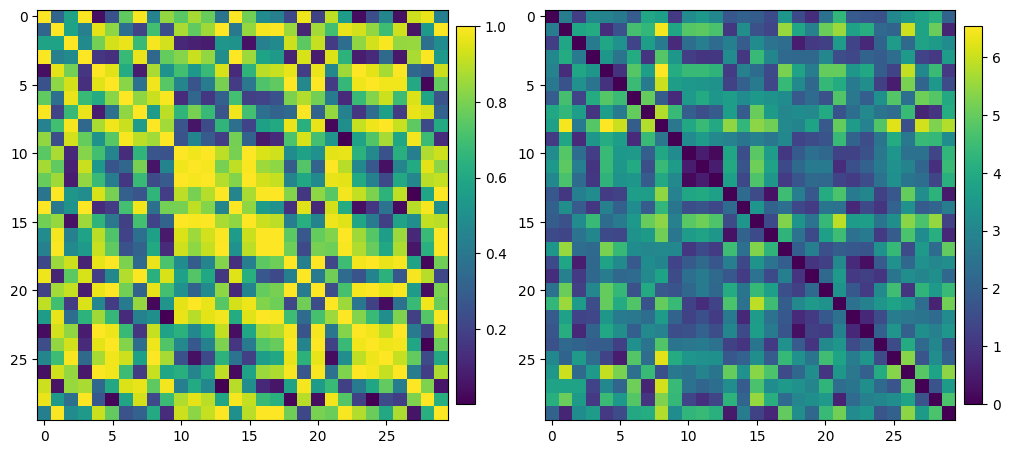

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10), constrained_layout=True)
# fig.tight_layout()

im1 = ax1.imshow(np.abs(corr_matrix))
fig.colorbar(im1, fraction=0.046, pad=0.02)

im2 = ax2.imshow(dist_matrix)
fig.colorbar(im2, fraction=0.046, pad=0.02)

In [ ]:
plt.imshow(np.multiply(np.abs(corr_matrix), dist_matrix))
plt.colorbar()

In [ ]:
plt.imshow(A)

In [ ]:
eigval = nump.zeros((1000,60))
xdot_reshape_proj = nump.zeros((1000,60))
eigvec_sort = nump.zeros((60,60))

for t in range(1000):
  hess = jacfwd(jacrev(energy_harmonic, argnums=0), argnums=0)(sol_t_0_1.ys[0][t], K)
  hess_reshape = np.reshape(hess,(particle_count*2,particle_count*2))
  eigval[t], eigvec = np.linalg.eig(hess_reshape)

  eigvec_sort = eigvec[:, np.squeeze(np.argsort(eigval[[t]]))]

  xdot = jacrev(ctrl_hamiltonian_in_out, argnums=1)(sol_t_0_1.ys[0][t], sol_t_0_1.ys[1][t])
  xdot_reshape = np.reshape(xdot, particle_count*2)

  xdot_reshape_proj[t] = np.matmul(xdot_reshape, eigvec_sort)


<ipython-input-167-6e640b13d7db>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  eigval[t], eigvec = np.linalg.eig(hess_reshape)
<ipython-input-167-6e640b13d7db>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  xdot_reshape_proj[t] = np.matmul(xdot_reshape, eigvec_sort)


In [ ]:
# arr = nump.array([4,2,6,1])
# temp = nump.array([[1,2,3,6],[4,5,6,4],[7,8,9,8]])

# print(arr)
# print(nump.transpose(temp))

# print(np.matmul(arr, nump.transpose(temp)))

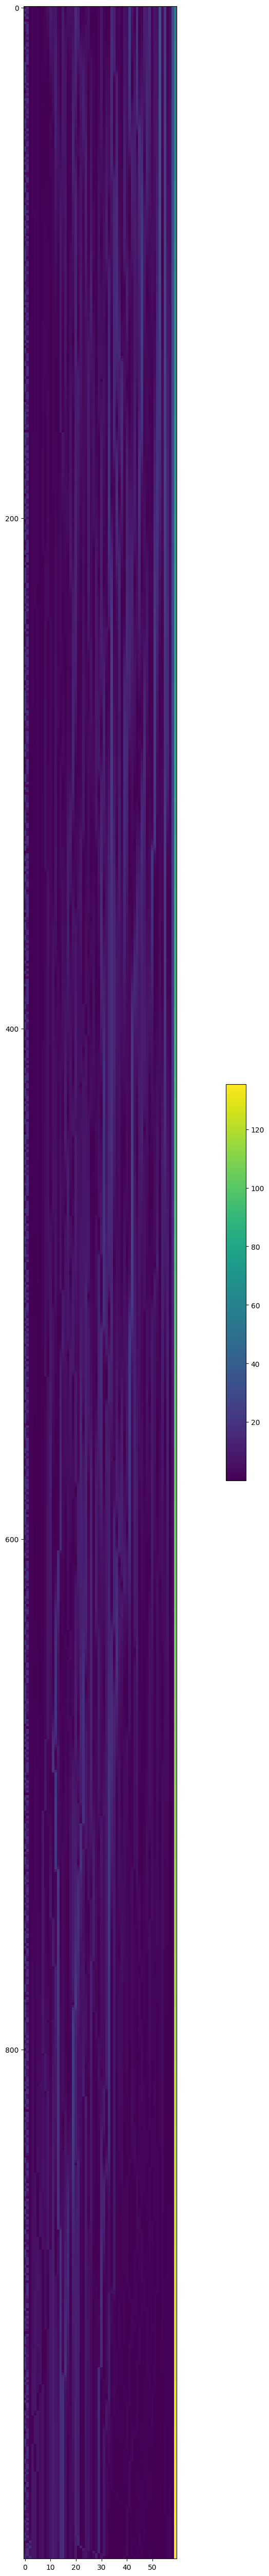

In [ ]:
fig, ax = plt.subplots(figsize=(50,50), constrained_layout=True)
im = ax.imshow(np.abs(xdot_reshape_proj))
fig.colorbar(im, fraction=0.008, pad=0.02)

##Uncontrolled Dynamics

In [ ]:
key = random.PRNGKey(10)

particle_count = 30
dim = 2

# volume = 8
# number_density = particle_count / volume

box_size = box_size_at_number_density(particle_count = particle_count,
                                      number_density = 1.2,
                                      spatial_dimension = dim)

R = random.uniform(key, (particle_count, dim), maxval=3, minval=-3)
x=R

In [ ]:
from jax_md.colab_tools import renderer
renderer.render(box_size, renderer.Disk(R), resolution=(600, 600))

In [ ]:
def adjacency_mat(r,d):
  return np.where((r < d) & (r > 0),
                  1,
                  0.)

displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

dist_matrix = metric(x, x)

A = adjacency_mat(dist_matrix,1.5)
A = np.triu(A,0)

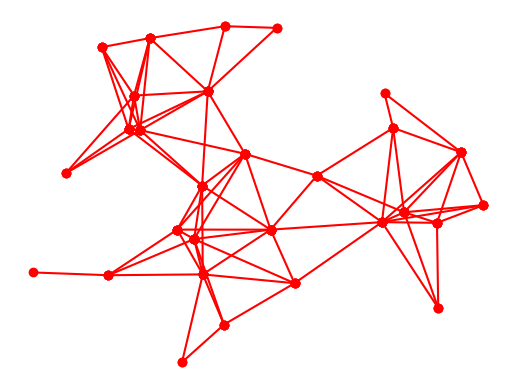

In [ ]:
fig, ax = plt.subplots()

X = np.array([x[np.where(A)[0]],x[np.where(A)[1]]])
ax.plot(X[:,:,0],X[:,:,1], 'ro-', zorder=1)
ax.axis('off')

plt.show()

In [ ]:
def energy_harmonic(x,K):
  dr = metric(x, x)
  return 0.5 *np.sum(np.multiply(K,np.square(dr - l)))

In [ ]:
def fwd_dyn_od_unc(t, G, args):
  x = G
  xdot = -jacrev(energy_harmonic, argnums=0)(x,K)
 # Lambdadot = -jacrev(ctrl_hamiltonian_in_out, argnums=0)(x,Lambda)
  F = xdot
  return F

In [ ]:
x0 = x
#Lambda0 = 0.0*np.ones(x0.shape)
K=0.1
#x_tar = 4
#t0 = 0
#t1 = 0.5
l=0.2
t0=0.0
t1=1

In [ ]:
solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

#fwd_sol = diffeqsolve(ODETerm(fwd_dyn_od), solver, t0=t0, t1=t1, dt0=0.00001, y0=[np.float64(x0),np.float64(Lambda0)], saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)
fwd_sol = diffeqsolve(ODETerm(fwd_dyn_od_unc), solver, t0=t0, t1=t1, dt0=0.00001, y0=np.float64(x0), saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)

In [ ]:
fwd_sol

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1000],
  ys=f64[1000,30,2],
  interpolation=None,
  stats={
    'max_steps':
    None,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [ ]:
eigval = nump.zeros((1000,60))
xdot_reshape_proj = nump.zeros((1000,60))
eigvec_sort = nump.zeros((60,60))


for t in range(1000):
  hess = jacfwd(jacrev(energy_harmonic, argnums=0), argnums=0)(fwd_sol.ys[t], K)
  hess_reshape = np.reshape(hess,(particle_count*2,particle_count*2))
  eigval[t], eigvec = np.linalg.eig(hess_reshape)

  eigvec_sort = eigvec[:, np.squeeze(np.argsort(eigval[[t]]))]

  xdot = -jacrev(energy_harmonic, argnums=0)(fwd_sol.ys[t], K)
  xdot_reshape = np.reshape(xdot, particle_count*2)

  xdot_reshape_proj[t] = np.matmul(xdot_reshape, eigvec_sort)


<ipython-input-162-4bd00c22aba1>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  eigval[t], eigvec = np.linalg.eig(hess_reshape)
<ipython-input-162-4bd00c22aba1>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  xdot_reshape_proj[t] = np.matmul(xdot_reshape, eigvec_sort)


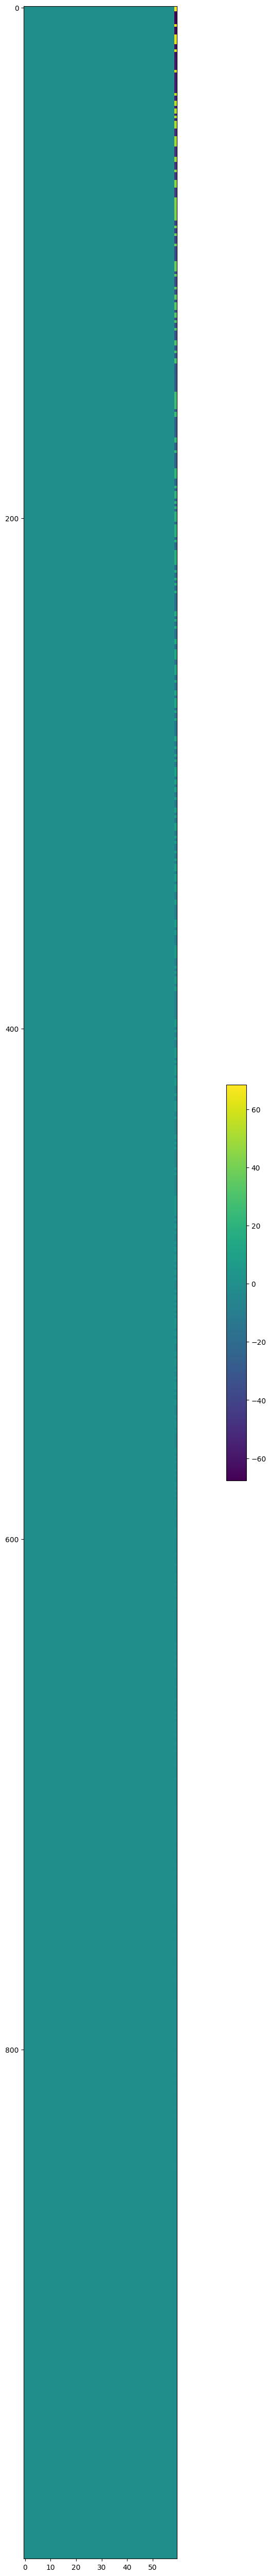

In [ ]:
fig, ax = plt.subplots(figsize=(50,50), constrained_layout=True)
im = ax.imshow(xdot_reshape_proj)
fig.colorbar(im, fraction=0.008, pad=0.02)

In [ ]:
mechanical_energy=[]
for i in range(1000):
  mechanical_energy.append(energy_harmonic(fwd_sol.ys[i,:,:],K))
  #plt.scatter(i, energy_harmonic(fwd_sol.ys[i,:,:], K))


In [ ]:
mechanical_energy=np.array(mechanical_energy)

Text(0, 0.5, 'E(t)')

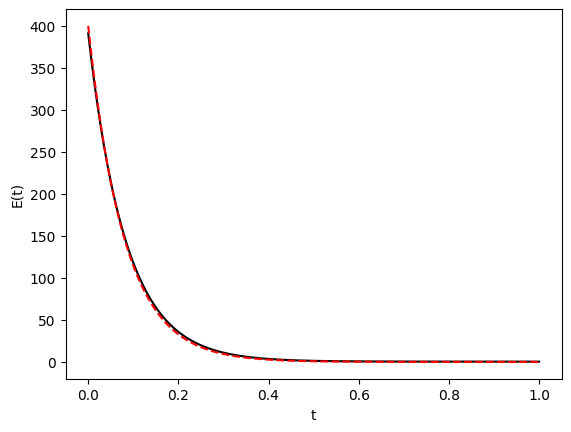

In [ ]:
plt.plot(fwd_sol.ts,mechanical_energy,'-k' )
plt.plot(fwd_sol.ts,400*np.exp(-fwd_sol.ts/0.08),'--r')
plt.xlabel('t')
plt.ylabel('E(t)')

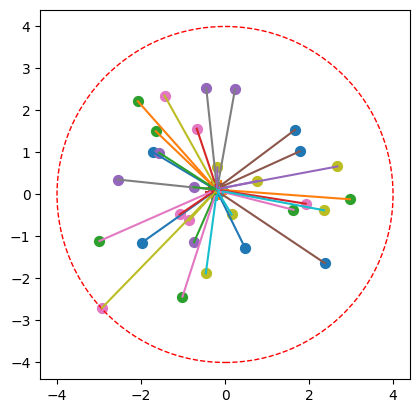

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

# print(harmonic_sol)
for i in range(particle_count):
  ax.plot(fwd_sol.ys[:,i,0],fwd_sol.ys[:,i,1])
  ax.scatter(fwd_sol.ys[0,i,0],fwd_sol.ys[0,i,1],marker='o',s=50)
  ax.scatter(fwd_sol.ys[-1,i,0],fwd_sol.ys[-1,i,1],marker='+',s=50)
# plt.plot(harmonic_sol.ts,harmonic_sol.ys[0][:,0,:])
ax.add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='r',fill=False))
plt.show()

In [ ]:
sol=fwd_sol
sol

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1000],
  ys=f64[1000,30,2],
  interpolation=None,
  stats={
    'max_steps':
    None,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [ ]:
T=100

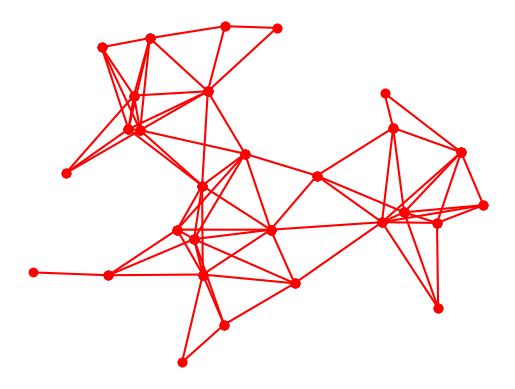

In [ ]:
fig, ax = plt.subplots()

X = np.array([sol.ys[i][np.where(A)[0]],sol.ys[i][np.where(A)[1]]])
ax.plot(X[:,:,0],X[:,:,1], 'ro-', zorder=1)
ax.axis('off')

plt.show()

In [ ]:
X=np.array([sol.ys[i][np.where(A)[0]],sol.ys[i][np.where(A)[1]]])
X.shape

(2, 77, 2)

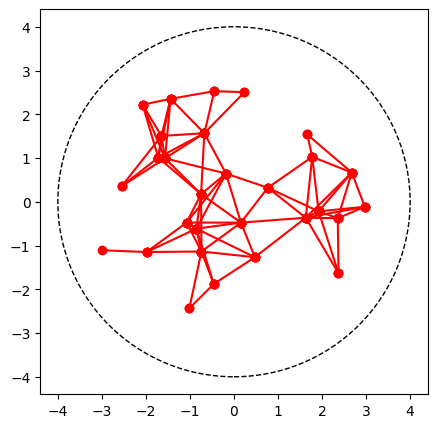

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(j):
    ax.clear()
    #bgrnd = ax.scatter(x_coord, y_coord, c=, s=10, cmap='YlOrRd')
    i=10*j
    X = np.array([sol.ys[i][np.where(A)[0]],sol.ys[i][np.where(A)[1]]])
    fgrnd1 = ax.plot(X[:,:,0],X[:,:,1], 'ro-')
    #fgrnd = ax.scatter(sol.ys[0][i,:,0], sol.ys[0][i,:,1], s=50)
    traj1= ax.plot(sol.ys[0:i,0,0],sol.ys[0:i,0,1],'--g')
    traj2= ax.plot(sol.ys[0:i,5,0],sol.ys[0:i,5,1],'--y')
    traj3= ax.plot(sol.ys[0:i,10,0],sol.ys[0:i,10,1],'--m')
    traj4= ax.plot(sol.ys[0:i,15,0],sol.ys[0:i,15,1],'--r')
    circ= ax.add_patch(plt.Circle((0, 0), x_tar, linestyle='--', color='k',fill=False))
    #return bgrnd,fgrnd
    return fgrnd1,circ

ani = FuncAnimation(fig, animate, interval=10, blit=False, repeat=True, frames=T)
ani.save("uncontrolled.gif", dpi=300, writer=PillowWriter(fps=10))